<a href="https://colab.research.google.com/github/georgeliu1998/keras_model_tuning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
from time import time
import importlib # for dynamic class instantiation from a string
from copy import deepcopy

from sklearn.model_selection import StratifiedKFold, cross_val_score
#from sklearn.preprocessing import StandardScaler

import xgboost as xgb


from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [0]:
from numpy.random import seed
seed(6)
from tensorflow import set_random_seed
set_random_seed(6)

seed = np.random.RandomState(6)

In [3]:
# Mount gdrive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
class SequentialModel:
  """
  The base class for a Neural Networks model
  """
  
  def __init__(self, input_dim, num_layers, num_units, 
               activation, activation_out, 
               loss, initializer, optimizer, learning_rate, 
               metrics, epochs, batch_size, one_hot=False):
    """
    Params:
      input_dim: int, number of features
      num_layers: int, number of layers of the model (excluding the input layer)
      num_units: list, number of units in each layer(excluding the input layer)
      activation: str, activation function used in all layers except output
      activation_out: str, activation function used in output layer
      loss: str, loss functon
      initializer: str, kernel initializer
      optimizer: str, optimizer
      metrics: list of strings, metrics used
      epochs: int, number of epochs to train for
      batch_size: int, number of samples per batch
      one_hot: bool, whether one hot encoding is needed
    """
    self.input_dim = input_dim
    self.num_layers = num_layers
    self.num_units = [num_units, 1]
    self.activation = activation
    self.activation_out = activation_out
    self.loss = loss
    self.initializer = initializer
    self.optimizer = optimizer
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.epochs = epochs
    self.batch_size = batch_size
    self.one_hot = one_hot
    
    # Initialize the sequential model
    self.model = Sequential()

    
  def build_model(self):
    """
    Adds layers and compiles the model
    """
    # Ensure num_units tuple's length is the same as num_layers
    if self.num_layers != len(self.num_units):
      # Expand the list by repeating number of nodes except for last layer
      num_nodes, num_nodes_out = self.num_units[0], self.num_units[-1]
      self.num_units = [i for i in range(self.num_layers-1) for i in [num_nodes]]
      self.num_units.append(num_nodes_out) 
 
    # Loop thru all the layers
    for i in range(self.num_layers):
      # different layers should have different setups
      if i == 0: # input and first hidden layer
        self.model.add(Dense(units=self.num_units[i],
                             input_dim=self.input_dim,
                             kernel_initializer=self.initializer,
                             activation=self.activation)) 
      elif i+1 == self.num_layers: # output layer
        self.model.add(Dense(units=self.num_units[i],
                             kernel_initializer=self.initializer,
                             activation=self.activation_out))
      else: # hidden layers
        self.model.add(Dense(units=self.num_units[i],
                            kernel_initializer=self.initializer,
                            activation=self.activation))
    
    # Instantiate the optimizer class
    optimizer_class = getattr(importlib.import_module("keras.optimizers"), 
                             self.optimizer)
    self.optimizer = optimizer_class(lr=self.learning_rate)
    # Compile the model
    self.model.compile(loss=self.loss,
                       optimizer=self.optimizer,
                       metrics=self.metrics)
        
  
  def evaluate_model(self, X, y, n_splits=3):
    """
    Evaluates the model using cross-validation.
    
    Params:
      X: np.array, features
      y: np.array, labels
      n_splits: int, number of folds for the cross-validation
    Returns:
      mean_accuracy: float, the average accuracy based on the cross-validation.
    
    """
    score_lst = []
    t1 = time()
    
    print("Starting {}-fold cross-validation...".format(n_splits))
    
    kfold = StratifiedKFold(n_splits=n_splits, 
                            shuffle=True, 
                            random_state=seed)
    
    # Loop through the different folds
    for train_index, test_index in kfold.split(X, y):
      # Do one-hot encoding when needed
      if self.one_hot:
        y_one_hot = to_categorical(y)
      else:
        y_one_hot = y
        
      self.model.fit(X[train_index],
                     y_one_hot[train_index],
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     verbose=0)
        
      scores = self.model.evaluate(X[test_index],
                                   y_one_hot[test_index], 
                                   verbose=0)
            
      # The second item is accuracy
      score_lst.append(scores[1])

    t2 = time()
    t = t2 - t1
    # Convert time to mintues
    t /= 60

    print("Finished cross-valiation. Took {:.1f} mintues.".format(t))

    # Convert to np.array and calculate mean and sd
    score_lst = np.array(score_lst)
    mean_acc = score_lst.mean()
    sd_acc = score_lst.std()

    print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(mean_acc, sd_acc))
    return mean_acc

In [0]:
def get_defaults(input_dim=8, 
                 num_layers=2,
                 num_units=8,
                 activation='relu',
                 activation_out='sigmoid',
                 loss='binary_crossentropy',
                 initializer='random_uniform',
                 optimizer='adam',
                 learning_rate=0.001,
                 metrics=['accuracy'],
                 epochs=10, 
                 batch_size=4,
                 one_hot=False):
  """
  Returns a dict of default hyperparameter values
  """

  defaults = {'input_dim': input_dim, 
              'num_layers': num_layers, 
              'num_units': num_units, 
              'activation': activation, 
              'activation_out': activation_out, 
              'loss': loss, 
              'initializer': initializer, 
              'optimizer': optimizer, 
              'learning_rate': learning_rate, 
              'metrics': metrics, 
              'epochs': epochs, 
              'batch_size': batch_size, 
              'one_hot': one_hot}
  
  return defaults


def get_tuning_options(**kwargs):
  """
  Define tuning parameter and corresponding options
  
  Params:
    -----------------####################
  Returns:
    -----------------####################
  
  """ 
  tuning_options = {}
  
  for param, options in kwargs.items():
    tuning_options[param] = options 
  
  return tuning_options

In [0]:
def build_eval(X, y, param_dict):
  """
  Builds a Neural Network model using the given params and returns the 
  cross-validation accuracy
  
  Params:
    param_dict: dict - Python dict containing the tuning parameters and values
  
  Returns:
    result: float - percentage accuracy based on cross-validation
  """
  model = SequentialModel(input_dim=param_dict['input_dim'], 
                          num_layers=param_dict['num_layers'], 
                          num_units=param_dict['num_units'],
                          activation=param_dict['activation'], 
                          activation_out=param_dict['activation_out'], 
                          loss=param_dict['loss'], 
                          initializer=param_dict['initializer'], 
                          optimizer=param_dict['optimizer'], 
                          learning_rate=param_dict['learning_rate'], 
                          metrics=param_dict['metrics'], 
                          epochs=param_dict['epochs'], 
                          batch_size=param_dict['batch_size'], 
                          one_hot=param_dict['one_hot'])
  model.build_model()
  result = model.evaluate_model(X, y)
  
  return result


def run_test(X, y, param_dict, tuning_options=None):
  """
  Tests different parameter's accurcy using the given tuning options

  Params:
    -----------------####################
  Returns:
    -----------------####################

  """
  if tuning_options:
    results = {}
        
    for parameter, options in  tuning_options.items():
      results[parameter] = {}
      param_dict_temp = deepcopy(param_dict)
      
      for option in options:
        print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))
        # Update the corresponding parameter
        param_dict_temp[parameter] = option
        
        try:
          #print("param_dict_temp: {}".format(param_dict_temp))
          results[parameter][option] = build_eval(X, y, param_dict_temp)
        except Exception as e: 
          results[parameter][option] = 'NaN'
          print('Error: {}, skipping...'.format(e))
          pass
    return results
  
  else:
    return build_eval(X, y, param_dict)

In [0]:
def wrangle_results(results):
    """
    
    Params:
      results: dict - the results dict returned by the build_eval() function

    Returns:
        df_plot: pandas df, the wrangled long format dataframe
    """
    df = pd.DataFrame(results)
    # Get the col names as value vars for melt func
    value_vars = df.columns.tolist()
    # Reset index and rename the index col 
    df = df.reset_index().rename(columns={'index': 'option'})
    # Transform from wide to long format for easy plotting
    df_long = pd.melt(df, id_vars='option', value_vars=value_vars)
    df_long = df_long.rename(columns={'variable': 'parameter'})
    # Exclude the zero and null values
    df_long = df_long[~df_long['value'].isnull()]
    df_long = df_long.query("value!=0 & value!='NaN'")

    # Calculate the range and sd of each parameter group and convert to a df
    ranges = df_long.groupby('parameter').apply(lambda grp: grp.value.max() - grp.value.min())
    sd = df_long.groupby('parameter').apply(lambda grp: grp.value.std())
    spread = pd.concat([ranges, sd], axis=1).rename(columns={0: 'ranges', 1: 'sd'})
    # Join back the df
    df_spread = pd.merge(df_long, spread, how='left', left_on='parameter', right_index=True)
    # Reorder columns
    df_spread = df_spread[['parameter', 'option', 'value', 'ranges', 'sd']]
    # Remove the row with zero value
    df_spread = df_spread.query('ranges!=0')
    # Change column dtype
    df_spread['value'] = df_spread['value'].astype(float)
    # Sort the dataframe and use the resulting index to slice
    # This ensures the plot will be ordered accordingly
    idx = df_spread.sort_values(by=['ranges', 'option'], ascending=False).index
    df_plot = df_spread.loc[idx, :]
    
    return df_plot


def visualize_distribution(df):
  fig, ax = plt.subplots(figsize=(16, 12))
  df['value'] =  df['value'].astype(float)
  sns.boxplot(x='parameter', y='value', data=df, ax=ax)
  sns.swarmplot(x='parameter', y='value', data=df, size=12, ax=ax)
  ax.set_xlabel('Parameters',size=20)
  ax.set_ylabel('Values',size=20)

In [0]:
  def get_best_options(df):
    #df =  df.query("parameter==@param")
    best_options = df.groupby('parameter').apply(lambda grp: grp.nlargest(1, 'value'))[['parameter', 'option']].values.tolist()
    return best_options

In [0]:
def visualize_trend(df):
  """
  Visualizes a parameter's tuning trend

  Params:
    param - string, the parameter to visualize
  returns:
    best_option: string/integer/float, option with the best accuracy for the given parameter 
  """
  fig, ax = plt.subplots(figsize=(12, 8))
  df.plot(x='option', y='value', ax=ax) 
  ax.set_xlim(df.option.min()*0.9, df.option.max()*1.1)
  plt.show()

In [9]:
df = pd.read_csv("/content/gdrive/My Drive/pima-indians-diabetes.csv", header=None)
print(df.head())

# Get the features and labels as np arrays
X, y = df.values[:, 0:8], df.values[:, 8]
print(X.shape, y.shape)

   0    1   2   3    4     5      6   7  8
0  6  148  72  35    0  33.6  0.627  50  1
1  1   85  66  29    0  26.6  0.351  31  0
2  8  183  64   0    0  23.3  0.672  32  1
3  1   89  66  23   94  28.1  0.167  21  0
4  0  137  40  35  168  43.1  2.288  33  1
(768, 8) (768,)


In [9]:
# Get baseline accuracy using XGBoost
t1 = time()
clf = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=3, random_state=seed)
scores = cross_val_score(clf, X, y, cv=cv)
t2 = time()
t = t2 - t1

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))
print("Time taken: {:.2f} seconds".format(t))

Mean Accuracy: 77.61%, Standard Deviation: 3.07%
Time taken: 0.12 seconds


In [10]:
param_dict = get_defaults()
param_dict

{'activation': 'relu',
 'activation_out': 'sigmoid',
 'batch_size': 4,
 'epochs': 10,
 'initializer': 'random_uniform',
 'input_dim': 8,
 'learning_rate': 0.001,
 'loss': 'binary_crossentropy',
 'metrics': ['accuracy'],
 'num_layers': 2,
 'num_units': 8,
 'one_hot': False,
 'optimizer': 'adam'}

In [11]:
num_units = [4, 8, 16, 32, 64]
num_layers = [2, 4, 8, 16, 32]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
initializer = ['random_uniform', 'random_normal', 'TruncatedNormal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.001, 0.002, 0.01, 0.1, 1]
optimizer = ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']
epochs = [10, 20, 40, 80, 160]
batch_size = [1, 2, 4, 8, 16]


tuning_options = get_tuning_options(num_units=num_units, 
                                    num_layers=num_layers, 
                                    loss=loss, 
                                    initializer=initializer,
                                    learning_rate=learning_rate, 
                                    optimizer=optimizer, 
                                    epochs=epochs, 
                                    batch_size=batch_size)
tuning_options

{'batch_size': [1, 2, 4, 8, 16],
 'epochs': [10, 20, 40, 80, 160],
 'initializer': ['random_uniform',
  'random_normal',
  'TruncatedNormal',
  'glorot_normal',
  'glorot_uniform'],
 'learning_rate': [0.001, 0.002, 0.01, 0.1, 1],
 'loss': ['binary_crossentropy',
  'categorical_crossentropy',
  'sparse_categorical_crossentropy'],
 'num_layers': [2, 4, 8, 16, 32],
 'num_units': [4, 8, 16, 32, 64],
 'optimizer': ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']}

In [11]:
# Get baseline accuracy using defauls with the defined Neural Networks class  
run_test(X, y, param_dict)

Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 70.45%, Standard Deviation: 1.39%


0.7044647134495444

In [15]:
results = run_test(X=X, y=y, param_dict=param_dict,
                   tuning_options=tuning_options)

# Save the dict    
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
    print("Results saved to Google Drive successfully!")


Evaluating parameter "num_units" using value "4"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 66.54%, Standard Deviation: 1.33%

Evaluating parameter "num_units" using value "8"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 66.54%, Standard Deviation: 1.85%

Evaluating parameter "num_units" using value "16"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 69.27%, Standard Deviation: 0.74%

Evaluating parameter "num_units" using value "32"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 70.31%, Standard Deviation: 0.09%

Evaluating parameter "num_units" using value "64"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 69.93%, Standard Deviation: 3.70%

Evaluating parameter "num_layers" using value "2"...
Starting 3-fold cross-validation.

In [0]:
# Load the pickled results dict
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [22]:
df = wrangle_results(results)
#visualize_distribution(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
param_dict = get_defaults()
best_options = get_best_options(df)

for i in best_options:
  param_dict[i[0]] = i[1]

build_eval(X=X, y=y, param_dict=param_dict)

Starting 3-fold cross-validation...
Finished cross-valiation. Took 15.9 mintues.
Mean Accuracy: 74.35%, Standard Deviation: 4.09%


0.7435070282038788

In [14]:
# The highest accuracy in the results
df.loc[[df.value.idxmax()]]

,parameter,option,value,ranges,sd
38,epochs,160,0.755236,0.071625,0.028172


In [15]:
# So let's save this combination as the best param_dict
param_dict_best = get_defaults(epochs=160)
param_dict_best

{'activation': 'relu',
 'activation_out': 'sigmoid',
 'batch_size': 4,
 'epochs': 160,
 'initializer': 'random_uniform',
 'input_dim': 8,
 'learning_rate': 0.001,
 'loss': 'binary_crossentropy',
 'metrics': ['accuracy'],
 'num_layers': 2,
 'num_units': 8,
 'one_hot': False,
 'optimizer': 'adam'}

In [16]:
build_eval(X=X, y=y, param_dict=param_dict_best)

Starting 3-fold cross-validation...
Finished cross-valiation. Took 4.3 mintues.
Mean Accuracy: 75.66%, Standard Deviation: 4.49%


0.7565584976233956

In [16]:
df

,parameter,option,value,ranges,sd
87,learning_rate,1,0.348957,0.352934,0.146414
105,learning_rate,0.1,0.651043,0.352934,0.146414
104,learning_rate,0.01,0.651043,0.352934,0.146414
103,learning_rate,0.002,0.701891,0.352934,0.146414
102,learning_rate,0.001,0.686256,0.352934,0.146414
38,epochs,160,0.755236,0.071625,0.028172
37,epochs,80,0.747475,0.071625,0.028172
36,epochs,40,0.734413,0.071625,0.028172
35,epochs,20,0.721438,0.071625,0.028172
33,epochs,10,0.683611,0.071625,0.028172


In [17]:
df.parameter.unique().tolist()

['learning_rate',
 'epochs',
 'initializer',
 'num_layers',
 'batch_size',
 'optimizer',
 'num_units']

In [49]:
params

['learning_rate',
 'epochs',
 'initializer',
 'num_layers',
 'batch_size',
 'optimizer',
 'num_units']

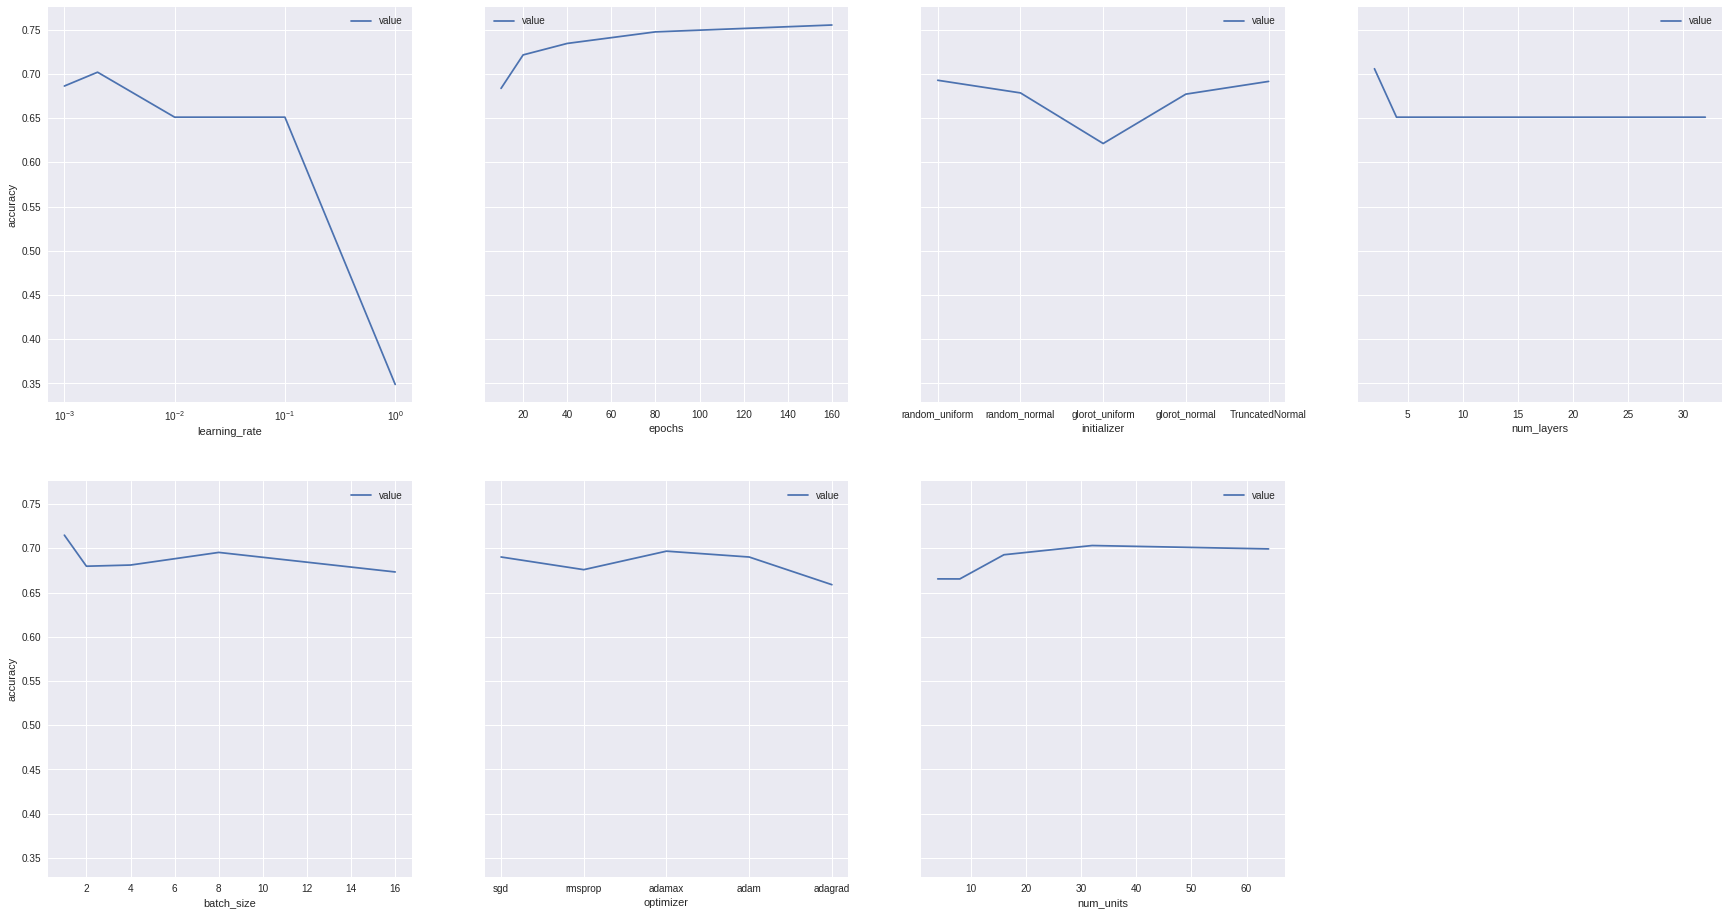

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(30, 16))
axes = axes.flatten()
params = df.parameter.unique().tolist()

for i, ax in enumerate(axes):
  try:
    param = params[i]
    df_param = df.query("parameter==@param")
    df_param.plot(kind='line', x='option', y='value', ax=ax)
    if param == 'learning_rate':
      ax.set_xscale('log')
    if param in ('initializer', 'optimizer'):
      ax.set_xticks(np.arange(5))
      ax.set_xticklabels(df_param.option)
    ax.set(xlabel=param, ylabel='accuracy') 
    #ax.get_legend().remove()
      
  except:
    fig.delaxes(ax)

plt.show()

In [0]:
learning_rate = [0.00095, 0.001, 0.0018, 0.0019, 0.002, 0.003] #0.00095

tuning_options = get_tuning_options(learning_rate=learning_rate)

result = run_test(tuning_options, X, y, use_defaults=False, param_dict=param_dict)

In [0]:
param_dict['learning_rate'] = 0.00095
param_dict

In [0]:
df_plot.query("parameter=='epochs'").plot(x='option', y='value')

In [0]:
epochs = [160, 180, 200, 220, 250] #0.00095

tuning_options = get_tuning_options(epochs=epochs)

result = run_test(tuning_options, X, y, use_defaults=False, param_dict=param_dict)

In [0]:
# Now tune batch_size
batch_size = [1, 2, 4, 8, 16, 32, 64, 128] #4
tuning_options = {'batch_size': batch_size}
result = run_test(tuning_options, X, y)
visualize(result, 'batch_size')

1. params class
2. download pima from kaggle
3. random search
4. plot title
5. code refactoring: given param dict, test results
6. normalize data